# 1. Практическое задание. Обучение полносвязной нейронной сети.

**ФИО**: Александрова Анна Антоновна

### Большая просьба

Называйте файл hw1_Фамилия.ipynb

In [168]:
import numpy as np
import torch
import cv2

from glob import glob
from collections import OrderedDict
from matplotlib import pyplot as plt

from torch import nn
from torch.autograd import Function
from torch.autograd import gradcheck
from torch.optim import Optimizer, Adam
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms

## 1. Загрузка данных (2 балла)

Если вам требуется работать с каким-нибубь набором данных (dataset), то прежде всего проверьте нет ли его среди встроенных наборов данных https://pytorch.org/vision/stable/datasets.html.

В текущем домашнем задании мы будем работать с набором данных FashionMNIST. Это не совсем про тексты, но зато он численный и его можно вытянуть в вектор. Это легко и полезно, чтобы отработать разные приемы. Он присутствует в списке встроенных наборов данных, однако мы воспользуемся реализацией только для удобного и быстрого способа скачать наборы данных. Ниже предлагается реализовать собственный класс для считывания, обработки и упаковки данных.

In [169]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True
)

In [170]:
print(type(training_data[0]))
print(type(training_data.data), type(training_data.targets))
print(training_data.data[0].shape, training_data.targets[0].shape)
print(training_data.data[0][0])

<class 'tuple'>
<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([28, 28]) torch.Size([])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0], dtype=torch.uint8)


Воспользуемся функцией загрузки данных из репозитория наборов данных.

In [171]:
! ls data/FashionMNIST/raw

t10k-images-idx3-ubyte	   t10k-labels-idx1-ubyte.gz   train-labels-idx1-ubyte
t10k-images-idx3-ubyte.gz  train-images-idx3-ubyte     train-labels-idx1-ubyte.gz
t10k-labels-idx1-ubyte	   train-images-idx3-ubyte.gz


In [172]:
#https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py

def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 28, 28)

    return images, labels

Для удобства PyTorch предоставляет ряд базовых классов `Dataset, DataLoader`, от которых предлагается отнаследоваться при разработке пользовательских классов. Базовый класс `Dataset` используется для загрузки и обработки данных, класс `DataLoader` используется для управления процессом загрузки данных, позволяет в многопоточном режиме загружать данные и упаковывать их.
Эти вспомогательные классы находятся в модуле `torch.utils.data`.

При наследовании от класса `torch.utils.data.Dataset` требуется переопределить метод `__len__`, который возвращает количество примеров в наборе данных, а также метод `__getitem__`, который позволяет получить доступ к примеру из набора данных по индексу.

Реализуем класс для FasionMnist.

Элементами датасета должны являться пары '(np.array, int)', массив имеет размерность `(28, 28)`, тип элемента `np.float32`.

In [173]:
class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, images, labels):
        return torch.from_numpy(images), torch.from_numpy(labels)

In [174]:
import os

class FashionMnist(Dataset):
    def __init__(self, path, train=True, transform=None):
        super().__init__()

        self.path = path
        self.train = train
        if train:
          self.images, self.labels = load_mnist(self.path)
        else:
          self.images, self.labels = load_mnist(self.path, kind='t10k')

        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.transform:
            sample = self.transform(np.array(self.images[idx], dtype='float64'), np.array(self.labels[idx], dtype='float64'))
        return sample

In [175]:
test_dataset = FashionMnist("data/FashionMNIST/raw", train=False, transform=ToTensor())
train_dataset = FashionMnist("data/FashionMNIST/raw", transform=ToTensor())

In [176]:
print(len(train_dataset), len(test_dataset))

60000 10000


In [177]:
print(type(train_dataset[0][0]), type(train_dataset[0][1]))
print(train_dataset[0][0].shape, train_dataset[0][1].shape)
train_dataset[0]

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([28, 28]) torch.Size([])


(tensor([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            1.,   0.,   0.,  13.,  73.,   0.,   0.,   1.,   4.,   0.,   0.,   0.,
            0.,   1.,   1.,   0.],
         [  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            3.,   0.,  36., 136., 127.,  62.,  54.,   0.,   0.,   0.,   1.,   3.,
            4.,   0.,   0.,   3.],
     

Визуализируйте случайные элементы набора данных.

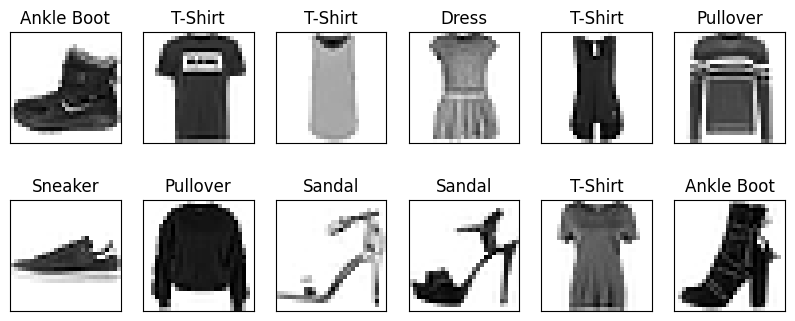

In [178]:
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot',}

plt.figure(figsize=(10, 4))
c = 0
for i, (image, label) in enumerate(train_dataset):
    image = image.reshape((28, 28))
    plt.subplot(2, 6, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(labels_map[label.item()])
    plt.imshow(image, cmap=plt.cm.binary)
    c += 1
    if c == 12:
        break
plt.show()

В конструктор `Dataset` можно передать объект `torchvision.transforms`, который позволяет преобразовать исходные данные. Преобразование `torchvision.transforms.ToTensor` позволяет преобразоать данные из типа `PIL Image` и `numpy.float32` в тип `torch.float32`

Реализуйте собственную поддержку преобразований в `FashionMnist`. Проверьте, что приведение типов работает корректно.

In [179]:
'''
Я использовала этот (такой же) класс в классе FashionMnist, для чего мне нужно было определить его раньше, чем FashionMnist. Ниже просто копия:

class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, images, labels):
        return torch.from_numpy(images), torch.from_numpy(labels)
'''

'\nЯ использовала этот (такой же) класс в классе FashionMnist, для чего мне нужно было определить его раньше, чем FashionMnist. Ниже просто копия:\n\nclass ToTensor:\n    """Convert ndarrays in sample to Tensors."""\n\n    def __call__(self, images, labels):\n        return torch.from_numpy(images), torch.from_numpy(labels)\n'

In [180]:
'''
А вот ещё разочек проверка работоспособности класса ToTensor:
'''
print(type(train_dataset[0][0]), type(train_dataset[0][1]))
print(train_dataset[0][0].shape, train_dataset[0][1].shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([28, 28]) torch.Size([])


Элементы набора данных могут быть объединены в пакеты (batch) явно и неявно. Если данные могут быть сконкатенированы или обЪединены каким-нибудь тривиальным способом, то можно не передавать никаких дополнительных парамертов в `torch.utils.data.Dataloader`.

In [181]:
test_dataloader = DataLoader(test_dataset, batch_size=15, num_workers=2, shuffle=True)
train_dataloader = DataLoader(train_dataset, batch_size=15, num_workers=2, shuffle=True)
torch_batch = next(iter(test_dataloader))

In [182]:
print(type(torch_batch), type(torch_batch[0]), type(torch_batch[0][0]))
torch_batch

<class 'list'> <class 'torch.Tensor'> <class 'torch.Tensor'>


[tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 

In [183]:
print(f"The length of the batch is {len(torch_batch)}")
print(f"The shape of the batch[0] is {torch_batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


Однако, если наша структура данных не позволяет нам использовать объединение по умолчанию, то можно написать собственную функцию, которая будет пакетировать данные.

Реализуйте функцию, преобразующую последовательность элементов массива в пакет (batch).

In [184]:
def collate_function(dataset, batch_size):
    all_batches = []
    one_batch = []
    one_batch_images = []
    one_batch_labels = []
    for sample in dataset:
        one_batch_images.append(sample[0])
        one_batch_labels.append(sample[1])
        if len(one_batch_labels) == batch_size:
            one_batch = [torch.stack(one_batch_images), torch.tensor(one_batch_labels)]
            all_batches.append(one_batch)
            one_batch = []
            one_batch_images = []
            one_batch_labels = []
    return all_batches

Убедитесть, что все работает корректно.

In [185]:
batch_size = 15

In [186]:
test_dataloader = collate_function(test_dataset, batch_size)
train_dataloader = collate_function(train_dataset, batch_size)
batch = next(iter(test_dataloader))

In [187]:
print(len(test_dataloader), len(train_dataloader))
print(type(batch), type(batch[0]), type(batch[0][0]))

666 4000
<class 'list'> <class 'torch.Tensor'> <class 'torch.Tensor'>


In [188]:
print(f"The length of the batch is {len(batch)}")
print(f"The shape of the batch[0] is {batch[0].shape}")

The length of the batch is 2
The shape of the batch[0] is torch.Size([15, 28, 28])


## 2. Реализация модулей нейронной сети (3 балла)

В этом разделе мы полностью реализуем модули для полносвязанной сети.

Для начала нам понадобится реализовать прямой и обратный проход через слои.

Наши слои будут соответствовать следующему интерфейсу (на примере "тождественного" слоя):

Сначала, мы реализуем функцию и её градиент.

In [189]:
class IdentityFunction(Function):
    """
    We can implement our own custom autograd Functions by subclassing
    torch.autograd.Function and implementing the forward and backward passes
    which operate on Tensors.
    """
    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we receive a Tensor containing the input and return
        a Tensor containing the output. ctx is a context object that can be used
        to stash information for backward computation. You can cache arbitrary
        objects for use in the backward pass using the ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        return input

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor containing the gradient of the loss
        with respect to the output, and we need to compute the gradient of the loss
        with respect to the input.
        """
        (input, ) = ctx.saved_tensors
        return grad_output

Разработанную функцию обернем классом `IdentityLayer`, все слои в `PyTorch` должны быть наследниками базового класса `nn.Module()`


In [190]:
class IdentityLayer(nn.Module):
    def __init__(self):
        # An identity layer does nothing
        super().__init__()
        self.identity = IdentityFunction.apply

    def forward(self, inp):
        # An identity layer just returns whatever it gets as input.
        return self.identity(inp)


### 2.1 Функция активации ReLU
Для начала реализуем функцию активации, слой нелинейности `ReLU(x) = max(x, 0)`. Параметров у слоя нет. Метод `forward` должен вернуть результат поэлементного применения `ReLU` к входному массиву, метод `backward` - градиент функции потерь по входу слоя. В нуле будем считать производную равной 0. Обратите внимание, что при обратном проходе могут понадобиться величины, посчитанные во время прямого прохода, поэтому их стоит сохранить в `ctx`.

In [191]:
class ReLUFunction(Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return torch.where(input < 0.0, 0.0, input)

    @staticmethod
    def backward(ctx, grad_output):
        (input, ) = ctx.saved_tensors
        out = torch.where(input <= 0, 0, 1)
        return grad_output * out


In [192]:
class ReLU(nn.Module):
    def __init__(self):

        super().__init__()
        self.relu = ReLUFunction.apply

    def forward(self, input):

        return self.relu(input)


Не забываем после реализации функции проверить градиент, испльзуя функцию `gradcheck`.

In [193]:
torch.manual_seed(0)

x = torch.rand((7,15), requires_grad = True, dtype=torch.double)
relu = ReLU()

assert gradcheck(relu, x)

In [194]:
torch_relu = torch.relu
our_relu = ReLU()

assert torch.norm(torch_relu(x.float()) - our_relu(x)) < 1e-5

### 2.2 Линейный слой (linear, fully-connected)
Далее реализуем полносвязный слой без нелинейности. У слоя два набора параметров: матрица весов (weights) и вектор смещения (bias).

In [195]:
class LinearFunction(Function):
    @staticmethod
    def forward(ctx, inp, weight, bias):
        ctx.save_for_backward(inp, weight, bias)

        output = (inp @ weight.T) + bias
        return output

    @staticmethod
    def backward(ctx, grad_output):
        (inp, weight, bias) = ctx.saved_tensors

        grad_bias = grad_output.sum(0)
        grad_weight = grad_output.T @ inp
        grad_input =  grad_output @ weight

        return grad_input, grad_weight, grad_bias

In [196]:
class Linear(nn.Module):
    def __init__(self, input_units, output_units):
        super().__init__()

        self.weight = torch.nn.Parameter(torch.rand(size=(output_units, input_units), dtype=torch.double, requires_grad=True))
        self.bias = torch.nn.Parameter(torch.rand(size=(output_units,), dtype=torch.double))
        self.linear = LinearFunction.apply

    def forward(self,inp):
        return self.linear(inp, self.weight, self.bias)


Проверим градиент, а также сравним с работой нашего модуля с имплементированным в `PyTorch`.

Проверка градиента:

In [197]:
torch.manual_seed(0)

x = torch.rand((6,12), requires_grad = True, dtype=torch.double)
linear = Linear(12, 14)

assert gradcheck(linear, x)

Сравнение с `PyTorch`.

In [198]:
output_units = 32
input_units = 15

x = torch.rand((16,15), requires_grad = True, dtype=torch.double)


weight = torch.rand(size=(output_units, input_units), dtype=torch.double)
bias = torch.rand(size=(output_units,), dtype=torch.double)

torch_linear = torch.nn.Linear(input_units, output_units, dtype=torch.double)
our_linear = Linear(input_units, output_units)


state_dict = OrderedDict([("weight", weight), ("bias", bias)])
torch_linear.load_state_dict(state_dict)
our_linear.load_state_dict(state_dict)



torch_forward = torch_linear.forward(x)
our_forward = our_linear(x)
assert torch.allclose(torch_forward, our_forward)

## 3. Сборка и обучение нейронной сети (5 баллов)

Реализуйте произвольную нейросеть, состоящую из ваших блоков. Она должна состоять из нескольких полносвязанных слоев.

Я вижу, что моя модель выдаёт не то, что нужно. У меня получаются тензоры с девятью отрицательными значениями и один нулем. Кажется, должно быть что-то другое))
Но уже головы не хватает понять, в чем проблема, поэтому сдаюсь как есть

In [199]:
class Network(nn.Module):
    def __init__(self, input_size=28*28, hidden_layers_size=32, num_layers=5,
                 num_classes=10):
        super().__init__()

        self.first_layer = nn.Sequential(
            Linear(input_size, hidden_layers_size),
            ReLU(),
            nn.Dropout(0.2)
        )

        hidden_layer_funcs = nn.ModuleList()
        for i in range(num_layers-2):
            hidden_layer_funcs.append(Linear(hidden_layers_size, hidden_layers_size))
            hidden_layer_funcs.append(ReLU())
            hidden_layer_funcs.append(nn.Dropout(0.2))

        self.hidden = nn.Sequential(*hidden_layer_funcs)
        self.pre_last_layer = Linear(hidden_layers_size, num_classes)
        self.last_layer = nn.LogSoftmax(dim=0)


    def forward(self, inp):
        x = self.first_layer(inp)
        x = self.hidden(x)
        x = self.pre_last_layer(x)
        x = self.last_layer(x)
        return x

Ниже вам предстоит написать цикл обучения. Сначала это бывает больно, но потом уже на автомате делается, в начале так всегда


In [200]:
class EmptyContext:
    def __enter__(self):
        pass

    def __exit__(self, *args):
        pass

In [201]:
# accuracy metric for our classififcation
def accuracy(model_labels, labels):
  return torch.mean((model_labels == labels).float())

In [202]:
my_dataloader = train_dataloader[:100] # это просто для отладки функций ниже

In [212]:
def perform_epoch(model, loader, criterion, optimizer=None, device=None):
    is_train = optimizer is not None
    if device:
        model.to(device)
    model.train()
    losses = []
    accuracy_s = []
    for images, labels in loader:
        images.to(device)
        labels.to(device)
        for i, image in enumerate(images):
            optimizer.zero_grad()
            output = model(image.flatten())  #так и не поняла, почему у меня получается 9 отрицательных вероятностей и одна нулевая....
            model_label = list(output).index(0)  #решила счиатать правильным ответом индекс нуля в получившемся тензоре, хотя это ерунда, конечно
            loss = criterion(torch.tensor(model_label), labels[i])
            loss.requires_grad = True
            accuracy_s.append(accuracy(model_label, labels[i]).item())
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

    return np.mean(losses), np.mean(accuracy_s)

Теперь обучим нашу нейронную сеть.

In [213]:
model = Network()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-6)
device = torch.device("cpu")
epochs = 5
for epoch in range(epochs):
    losses = []
    loss, acc = perform_epoch(model, my_dataloader, criterion, optimizer, device)
    losses.append(loss)
    print(f"Epoch - {epoch} : loss {loss}, accuracy {acc}")

Epoch - 0 : loss 11.436666666666667, accuracy 0.10466666666666667
Epoch - 1 : loss 11.422, accuracy 0.09266666666666666
Epoch - 2 : loss 11.619333333333334, accuracy 0.096
Epoch - 3 : loss 11.628666666666666, accuracy 0.09933333333333333
Epoch - 4 : loss 11.404, accuracy 0.09733333333333333


In [214]:
model

Network(
  (first_layer): Sequential(
    (0): Linear()
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
  )
  (hidden): Sequential(
    (0): Linear()
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear()
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear()
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
  )
  (pre_last_layer): Linear()
  (last_layer): LogSoftmax(dim=0)
)

Дальше:
- Проведите эксперименты с числом слоев.
- Постройте графики зависимости качества модели на тренировочной и тестовой выборках от числа слоев. Для получения статистически значимых результатов повторите эксперименты несколько раз.
- Сделайте выводы.

## 4. Бонусная часть.

### 4.1 Реализация метода оптимизации (1 балл).
Реализуйте сами метод оптимизации  для рассмотренной выше архитектуры. Вы можете выбрать произвольный метод от градиентного спуска до современных вариантов. Продемонстрируйте правильную работу метода оптимизации, сравните его работы с Adam.

**Дополнительные баллы** вы получите, если метод будет уникален среди сдавших задание.

In [ ]:
class SotaOptimizer(Optimizer):
    def __init__(self, params, lr=1e-3):
        defaults = dict(lr=lr)
        super(SotaOptimizer, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(SotaOptimizer, self).__setstate__(state)

    @torch.no_grad()
    def step(self,):

        for group in self.param_groups:
            lr = group['lr']
            for p in group['params']:
                if p.grad is not None:
                    p.data.add_(-lr*p.grad)

### 4.2 Реализация современной функции активации (1 балл).
Реализуйте одну из современных функций активации. Например, `Hardswish` или `GELU`. Сравните сеть с вашей активацией и с `ReLU`.

**Дополнительные баллы** вы получите, если функция будет уникальна среди сдавших задание.